In [2]:
import torch

print(torch.cuda.get_device_name(0))

NVIDIA GeForce RTX 4060 Laptop GPU


In [3]:
import sys
sys.path.append("./src")

import matplotlib.pyplot as plt
import numpy as np
from torchvision.io import read_image
from src.bounding_box import BBoxModel
from src.image_transformations.coordinate_transforms import *
from src.bounding_box import BBoxModel
from src.keypoints_detection.keypoint_model import KPModel
import PIL
import cv2
from src.keypoints_detection.hourglass import hg
from scipy.spatial.transform import Rotation
import os
import random
import pandas as pd

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
BBOX_MODEL_PATH = "./models/bbox_net_trained.pth"
KP_MODEL_PATH = "./models/keypoints_detection.pth"

test_dir = './data/GroundTruth'

bbox_model = BBoxModel(BBOX_MODEL_PATH)
kp_model = KPModel(KP_MODEL_PATH)

print(f"Using device: {bbox_model.device}")

Using device: cuda


In [5]:
def make_prediction(image_name):
    img = cv2.imread(f"{test_dir}/color/{image_name}.png")
    img_pill = PIL.Image.fromarray(img)
    depth_img = np.load(f'{test_dir}/depth/{image_name}.npy')
    K = IntrinsicsMatrix()

    bbox, score = bbox_model.find_bbox(img_pill)

    if bbox is not None:
        kpts = kp_model.predict(img, bbox)
        try:
            rotation, translation, img = kp_model.predict_position(K, depth_img, 12, img)
        except:
            print('raised exception predicting pose')
            return None
        if translation is not None and rotation is not None:
            return TransformationMatrix(R=rotation, t=translation)
        else:
            print('failure to predict pose')
            return None
    else:
        print('failure to predict bbox')
        return None

In [10]:
df = pd.read_csv("data/GroundTruth/fuelcap_data.csv")

samples = []
num_errors = 0
for idx, row in df.iterrows():
    if idx == 0:
        continue
    if row["OUT_OF_FRAME"] == True:
        print('rejected out of frame image')
        continue
    name = row["image_name"]
    x = row["dX"]
    y = row["dY"]
    z = row["dZ"] - (25 / 25.4)
    angle_mount = row["angle_mount"]
    angle_cap = row["angle_cap"]

    sample = dict()
    sample['image_name'] = name
    sample['measured_X'] = x
    sample['measured_Y'] = y
    sample['measured_Z'] = z
    sample['measured_angle_mount'] = angle_mount
    sample['measured_angle_cap'] = angle_cap

    H_ground_truth = calculate_matrix(x, y, z, angle_mount, angle_cap, units='in')
    H_prediction = make_prediction(name)

    sample['ground_truth_translation'] = H_ground_truth.as_pos_and_quat()[0].tolist()
    sample['ground_truth_rotation'] = H_ground_truth.as_pos_and_quat()[1].tolist()

    if H_prediction is not None:
        print(name)
        sample['prediction_translation'] = H_prediction.as_pos_and_quat()[0].tolist()
        sample['prediction_rotation'] = H_prediction.as_pos_and_quat()[1].tolist()
    else:
        sample['prediction_translation'] = "prediction error"
        sample['prediction_rotation'] = "prediction error"
        num_errors += 1
    
    samples.append(sample)
    

1700082959447
1700083030544
1700083066419
1700083079394
1700083113121
1700083139014
rejected out of frame image
rejected out of frame image
rejected out of frame image
1700083573884
rejected out of frame image
1700083778169
1700083803525
1700083820703
1700083847556
1700083865040
1700083880259
rejected out of frame image
1700084198296
1700084225173
1700084245105
1700084272193
1700084293026
1700088014586
1700088095696
1700088116871
1700088143424
1700088154181
1700088168216
failure to predict bbox
rejected out of frame image
rejected out of frame image
failure to predict bbox
failure to predict bbox
failure to predict bbox
failure to predict bbox
failure to predict bbox
rejected out of frame image
rejected out of frame image
failure to predict bbox
failure to predict bbox
failure to predict bbox
failure to predict bbox
failure to predict bbox
failure to predict bbox
failure to predict bbox


In [11]:
print(f'Successfully collected {len(samples) - num_errors} samples out of {len(samples)}')
print(f'\nFirst Sample:')
print(f'name={samples[0]["image_name"]}')
print(f'ground truth translation={samples[0]["ground_truth_translation"]}')
print(f'ground truth rotation={Rotation.from_quat(samples[0]["ground_truth_rotation"]).as_euler("xyz")}')
print(f'predicted translation={samples[0]["prediction_translation"]}')
print(f'predicted rotation={Rotation.from_quat(samples[0]["prediction_rotation"]).as_euler("xyz")}')

Successfully collected 24 samples out of 37

First Sample:
name=1700082959447
ground truth translation=[154.43312072753906, -191.8199920654297, 497.60894775390625]
ground truth rotation=[3.14156241e+00 1.06288809e-03 3.14107500e+00]
predicted translation=[182.46240234375, -202.03744506835938, 509.375]
predicted rotation=[2.99273952 0.07049483 3.07240522]


In [12]:
import json
# Save results
with open('./data/GroundTruth/prediction_results.json', 'w') as f:
    json.dump(samples, f)

In [15]:
# Load results
with open('./data/GroundTruth/prediction_results.json', 'r') as f:
    samples = json.load(f)

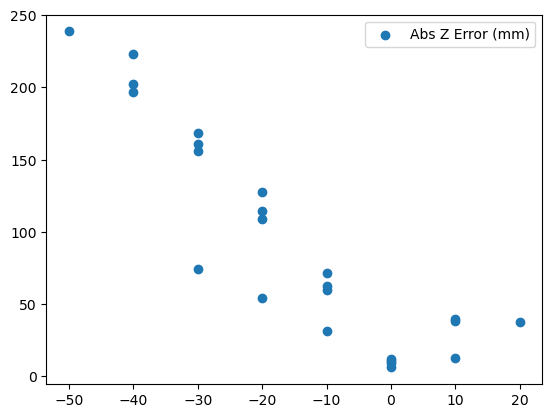

In [26]:
tz_ground_truths = []
tz_predictions = []
tz_errors = []
mount_angles = []
for sample in samples:
    if sample['prediction_translation'] == 'prediction error':
        continue
    ground_truth_tz = sample["ground_truth_translation"][2]
    prediction_tz = sample["prediction_translation"][2]
    mount_angle = sample["measured_angle_mount"]
    mount_angles.append(mount_angle)
    tz_ground_truths.append(ground_truth_tz)
    tz_predictions.append(prediction_tz)
    tz_errors.append(np.abs(prediction_tz - ground_truth_tz))

plt.scatter(mount_angles, tz_errors, marker='o', label='Abs Z Error (mm)')
#plt.scatter(mount_angles, tz_predictions, marker='o', label='predictions')
plt.legend()
plt.show()